# Clustering using RFM Analysis

Author: Khushee Kapoor

Last Updated: 4/1/22

#### *Q1 a.*  Read and write a summary of the metadata.

**Meta-Data** of the dataset:

The dataset contains data about the transactions occuring between 01/12/2010 and 09/12/2011 for a UK based online gift store. Attributes in the dataset:

Identifiers:
-   InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. Code starting with 'C' indicate cancellation.
-   StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.
-   CustomerID: Customer number. A 5-digit integral number uniquely assigned to each customer.



Categorical Data:
-   Country: Country name. The name of the country where each customer resides.
-   Description: Product (item) name.


Numeric Data:-   
-   InvoiceDate: Invice Date and time. The day and time when each transaction was generated.
-   Quantity: The quantities of each product (item) per transaction.
-   UnitPrice: Unit price. Product price per unit in sterling.



To start, we import the following packages:

-   NumPy: for data manipulation
-   Pandas: for data manipulation
-   MatPlotLib: for data visualization
-   Seaborn: for data visualization

In [2]:
# importing the libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Next, we read the dataset. To do this, we use the read_csv() function from the Pandas library. We set the index as the InvoiceDate column and also set the parse_dates parameter to True to convert the index column to the datetime datatype. 

In [3]:
# reading the dataset
df = pd.read_csv('../online_retail_II.csv', parse_dates=True, index_col='InvoiceDate')

After that, we view the first few rows of the dataset using the head() function from the Pandas library.

In [4]:
# viewing the first few rows
df.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country
InvoiceDate,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom


#### *Q1 b.* Select only the transactions that have occurred from 01/04/ 2011 and 09/12/2011 and create a dataset.

To solve Question 1b, we filter the dataset by comparing the index of the dataframe and store the filtered rows in a new dataframe called df_time. The date format is yyyy/mm/dd.

In [5]:
# extracting the transactions that have occured between 01/04/2011 and 09/12/2011
df_time = df[(df.index>='2011-04-01') & (df.index<='2011-12-09')]

Next, we check for missing values. To do this, we use the isnull() function from the Pandas library which returns a boolean array of whether the entry is null or not and then we sum over the null values using the sum() function.

In [6]:
# checking for missing values
df_time.isnull().sum()

Invoice            0
StockCode          0
Description      985
Quantity           0
Price              0
Customer ID    88936
Country            0
dtype: int64

As we can see there are 90853 missing values in the CustomerID column. Since CustomerID being an identifier is essential for the analysis, we drop the missing values. To do this, we filter the dataframe and use the function notna() from the Pandas library which chooses only those values which are not null.

In [7]:
# removing the missing values
df_time = df_time[df_time['Customer ID'].notna()]

Continuing with preprocessing, from the metadata, we can derive that some transactions were canceled. Hence, we need to remove them to get a more accurate analysis. To do that, we use the string function contains() and fiter out only those rows in the dataframe whose InvoiceID does not contain the character 'C'.

In [8]:
df_time = df_time[~df_time.Invoice.str.contains('C')]

After that, we check for duplicate records. To do this, we use the duplicated() function from the Pandas library.

In [9]:
df_time[df_time.duplicated()].shape

(3932, 7)

As we can see, there are 3730 duplicate records (values in all columns are identical). We decide to remove them in order to deal with them, to make our analysis more accurate. To do this, we select only those entries which are unique and keep only the first one of the duplicate entries by using the drop_duplicates() function from the Pandas library and set the keep parameter value as first.

In [10]:
df_time = df_time.drop_duplicates(keep='first')

We also check for any negative values in the Quantity and Price column and figure out a way to deal with them. To do this, we use filter the values in the column and sum them up.

In [11]:
print((df_time.Quantity<0).sum())
print((df_time.Price<0).sum())

0
0


As we can see, there are no negative values in these columns. Hence, the dataset is cleaned and ready to be analyzed.

#### *Q2.* Calculate R (Recency) − Recency should be calculated as the number of months before he or she has made a purchase from the online store. If he/she made a purchase in the month of December 2011, then the Recency should be 0. If purchase is made in November 2011 then Recency should be 1 and so on and so forth

To solve Question 2, we create a new column in the dataframe called R which stores the value of the month in the index column subtracted from 12 (since the month of reference/analysis is December). Hence, the most recent month gets value 0, second most recent gets 1, and so on..

In [12]:
# calculating R
df_time['R'] = 12 - df_time.index.month

#### *Q3.*  Calculate F (Frequency) − Number of invoices by the customer from 01/04/ 2011 and 09/12/2011.

To solve Question 3, we create a new column F and initialize all its rows to 0. Next, we create a list of all the unique cusotmer ids using the unique() function from the Pandas library. After that, we loop over the customer ids and add the number of invoices of a particular customer id to the F column. To do this, we use the loc() function from the Pandas library to locate exactly where the customer id matches the loop value, and add the size of the group of transactions made by the particular customer using the groupby() and size() functions from the Pandas library and splicing it.

In [13]:
# creating a new column and initializing to 0
df_time['F'] = 0

# creating a list of unique customer ids
customer_ids = list(df_time['Customer ID'].unique())

# calculating and storing the number of transactions made by each customer
for id in customer_ids:
  df_time.loc[df_time['Customer ID']==id, 'F'] += df_time.groupby(by='Customer ID').Invoice.size()[id]

#### *Q4.* Calculate M (Monetary Value) − Total spend by the customer from 01/04/ 2011 and 09/12/2011.

To solve Question 4, we first create a new column Revenue to store the product of the unit price and quantity of an item.

In [14]:
# calculating and storing the revenue
df_time['Revenue'] = df_time.Quantity * df_time.Price

Next, we create a new column M and initialize all its rows to 0. After that, we loop over the customer ids and add the revenue generated of a particular customer id to the M column. To do this, we use the loc() function from the Pandas library to locate exactly where the customer id matches the loop value, and add the sum of the revenue generated by the particular customer using the groupby() and sum() functions from the Pandas library and splicing it.

In [15]:
# creating a new column and initializing to 0
df_time['M'] = 0

# adding the sum of the revenue generated by each customer
for id in customer_ids:
  df_time.loc[df_time['Customer ID']==id, 'M'] += df_time.groupby(by='Customer ID').Revenue.sum()[id]

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_67639/4191705557.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16 1317.16
 1317.16 1317.16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_time.loc[df_time['Customer ID']==id, 'M'] += df_time.groupby(by='Customer ID').Revenue.sum()[id]


To solve further questions, we create a new dataframe to store only the unique customer ids and their RFM values. To do this, we use the DataFrame() and loc() functions from the Pandas library.

In [16]:
# creating a new dataframe
df_rfm = pd.DataFrame(customer_ids, columns=['Customer ID'])

In [17]:
# creating new columns and initializing to 0
df_rfm['R'] = 0
df_rfm['F'] = 0
df_rfm['M'] = 0

# updating value of each column
for id in customer_ids:
    df_rfm.loc[df_rfm['Customer ID']==id, 'R'] += df_time.loc[df_time['Customer ID']==id, 'R'].values[0]
    df_rfm.loc[df_rfm['Customer ID']==id, 'F'] += df_time.loc[df_time['Customer ID']==id, 'F'].values[0]
    df_rfm.loc[df_rfm['Customer ID']==id, 'M'] += df_time.loc[df_time['Customer ID']==id, 'M'].values[0]

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_67639/2291311728.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1317.16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_rfm.loc[df_rfm['Customer ID']==id, 'M'] += df_time.loc[df_time['Customer ID']==id, 'M'].values[0]


#### *Q5.* Create the customer segments with K-means algorithm by using number of clusters is suggested by elbow method.

To solve Question 5, we first import KMeans from the sklearn library.

In [18]:
# importing KMeans
from sklearn.cluster import KMeans

Next, we build models by looping over 1 to 10 clusters using the RFM values and storing the within-the-cluster-sum-of-squared-distance (wcss) of each cluster by using the inertia_ parameter of the kmeans model. Then, we plot the inertia wrt to the cluster number of all the clusters and analyze to find the elbow point using pointplot() function from the Seaborn library.

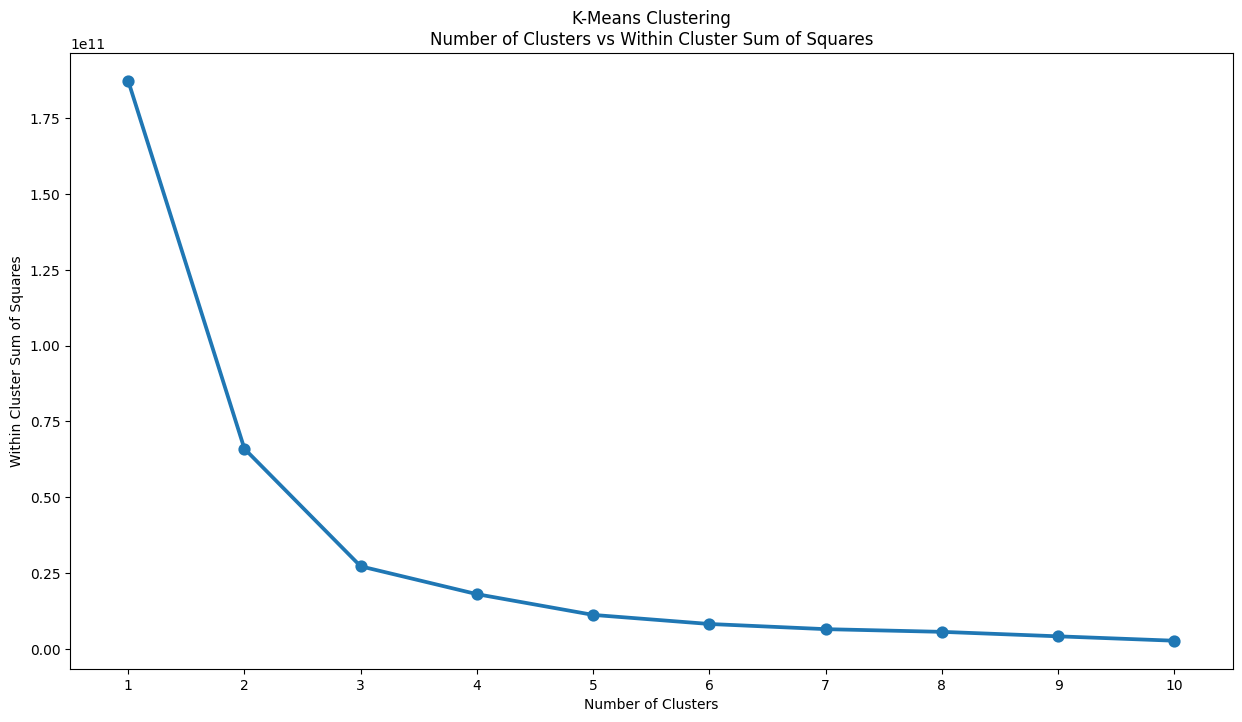

In [19]:
# creating a list to store the within-the-cluster-sum-of-squared-distance
wcss = []

# looping over number of clusters and storing wcss
for k in range(0, 10):
  kmeans = KMeans(n_clusters=k+1, random_state=0).fit(df_rfm[['R', 'F', 'M']])
  wcss.append(kmeans.inertia_)

# plotting the wcss wrt cluster numbers
plt.figure(figsize=(15,8))
ax = sns.pointplot(x=list(range(1, 11)), y=wcss)
ax.set_title('K-Means Clustering\nNumber of Clusters vs Within Cluster Sum of Squares')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Within Cluster Sum of Squares')
plt.show()

As we can see, an elbow point is formed at number of clusters - 3 as that is where the wcss starts changing slowly. Hence, we take the number of clusters to be 3.

#### *Q6 a.* Plot the clusters in a scatter plot and mark each segment differently using lmplot

To solve Question 6a, we first build a kmeans model with number of clusters to be 3 (as suggested by the elbow method) and fix the random_state for consistent results and use the RFM values.

In [20]:
# building the kmeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_rfm[['R', 'F', 'M']])

Next, we generate the cluster labels for each observation in the dataframe and store them in a column. For this, we use the labels_ parameter of the kmeans model.

In [21]:
# generating cluster labels
df_rfm['labels'] = kmeans.labels_

After that, we plot the clusters using the lmplot() function from the Seaborn library. We set the markers to be a circle, a triangle, and a diamond to better visualize the clusters and also set the the hue parameter to change the colour for every label.

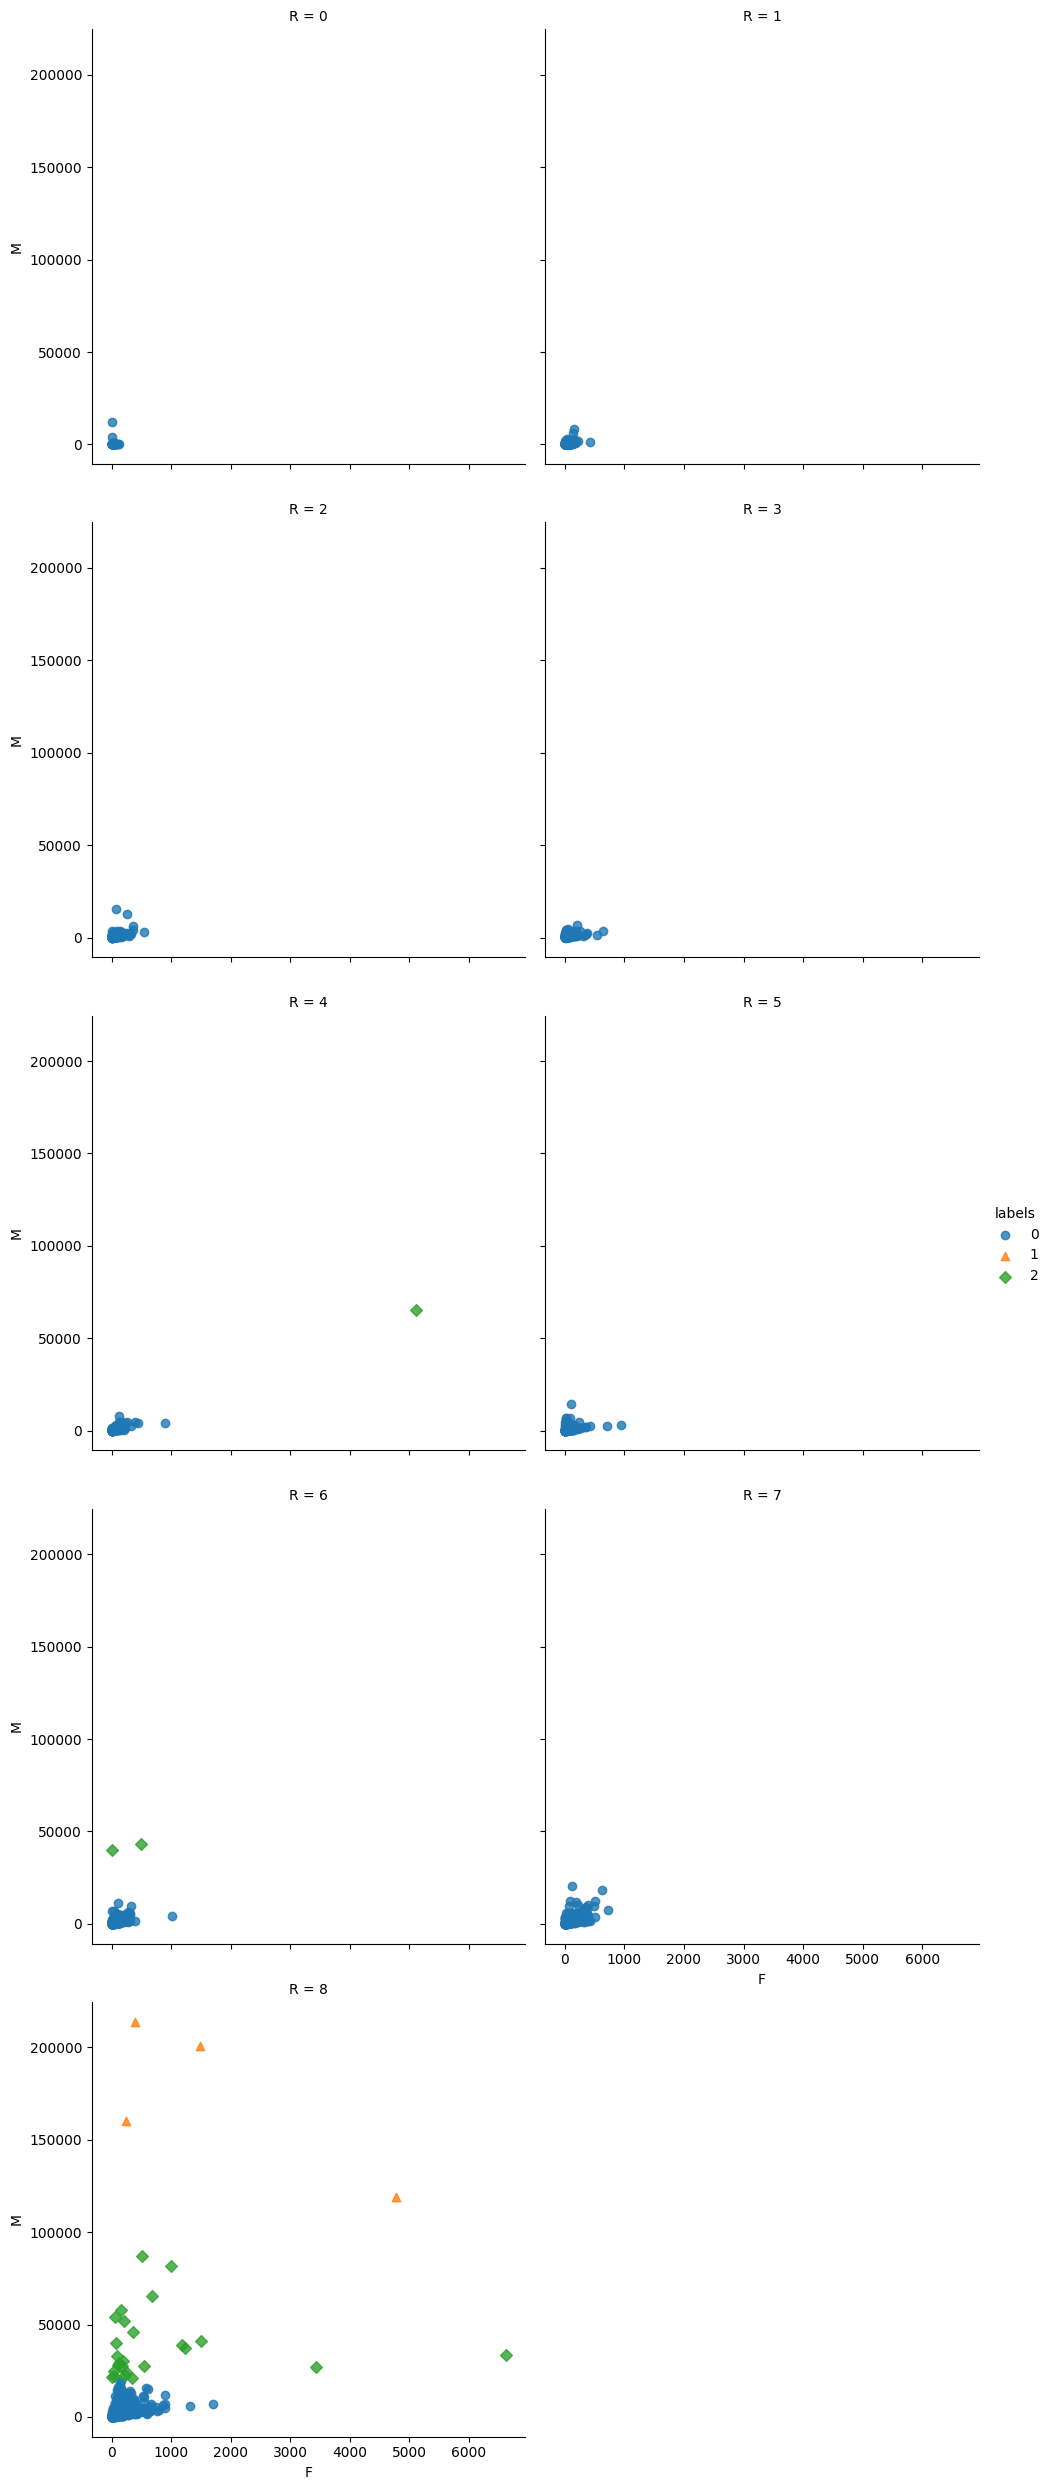

In [22]:
# visualizing the clusters
sns.lmplot(x='F', y='M', col='R', hue='labels', data=df_rfm, col_wrap=2, fit_reg=False, markers=['o', '^', 'D'])

As we can see, 9 plots have been generated - one for each value of Recency. On the x-axis, we have Monetary Value and on the y-axis we have Frequency. Each cluster has a different colour and a different shape. Cluster 0 is mostly located near the origin, with 2 closeby and 1 at the edges.

#### *Q6 b.* Print the cluster centers of each customer segment and explain them intuitively.

To solve Question 6b, we print the cluster centers using the cluster_centers_ parameter of the kmeans model.

In [23]:
# printing the cluster centres
kmeans.cluster_centers_

array([[5.00261986e+00, 6.99960702e+01, 1.23350022e+03],
       [8.00000000e+00, 1.72525000e+03, 1.73486923e+05],
       [7.71428571e+00, 8.85785714e+02, 4.00702357e+04]])

The cluster centre of cluster:

-  0 has a value of 4.38 for R, 68.6 for F, and 1212 for M (customers with Low Recency, Low Frequency and Low Monetary Value) - customers who are of little value.
-  1 has a value of 4.00 for R, 1296 for F, and 168158 for M (customers with Low Recency, High Frquency and High Monetary Value)  - loyal customers who should be entered in the Loyalty Program and given special benefits.
-  2 has a value of 5.25 for R, 865 for F, and 39738 for M (customers with Low Recency, Medium Frequency, and Medium Monetary Value) - occasional shoppers - should be sent more promos and offers.

The wcss values are caculated by summing up the squared distances between points and their cluster centers to analyze the quality of clusters (lesser the wcss, higher the quality).

#### *Q6 c.* Create the customer segments with Agglomerative algorithm by using number of clusters is suggested by elbow method.

To solve Question 6c, we first import AgglomerativeClustering from sklearn.

In [24]:
# importing Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

Next, we build an AgglomerativeClustering model with 3 clusters (as suggested by the elbow method previously) using the RFM values.

In [25]:
# building agglomerative clustering model
agglo = AgglomerativeClustering(n_clusters=3, compute_distances=True).fit(df_rfm[['R','F','M']])

#### *Q7 a.* Visualize the clusters using the dendrogram.

To solve Question 7a, we first import dendrogram from the scipy.cluster.heirarchy package.

In [26]:
# importing dendrogram
from scipy.cluster.hierarchy import dendrogram

Next, we write a function to plot the dendrogram. This function is taken from the official sklearn documentaion, and is aesthetically beautified using matplotlib functions.

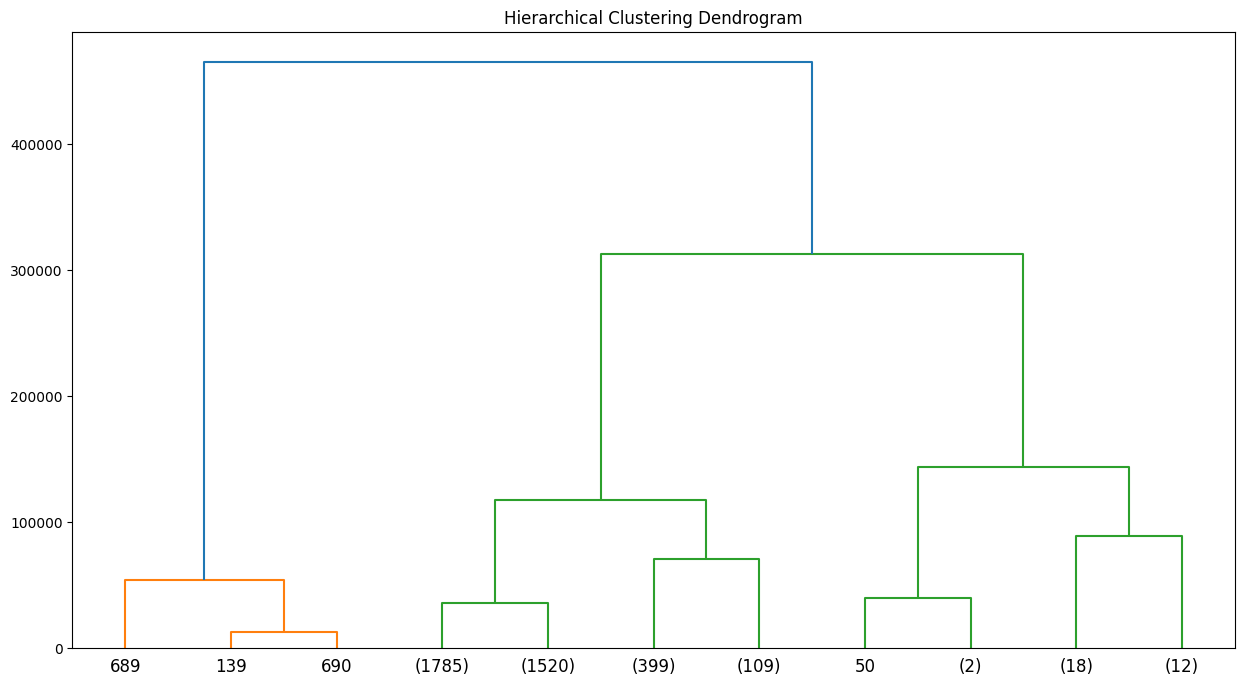

Cluster results saved to cluster.csv
Silhouette Score: 0.9557935970340762


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

def plot_dendrogram(agglo, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(agglo.children_.shape[0])
    n_samples = len(agglo.labels_)
    for i, merge in enumerate(agglo.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([agglo.children_, agglo.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

# Assuming 'agglo' is the result of an Agglomerative Clustering fit
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, truncate_mode='level', p=3)
plt.show()

# Add clustering results to the DataFrame
df_rfm['Cluster'] = agglo.labels_

# Create a new DataFrame with features and cluster labels
cluster_results = df_rfm[['R', 'F', 'M']].copy()
cluster_results.columns = [f'Feature_{i+1}' for i in range(cluster_results.shape[1])]
cluster_results['Cluster'] = df_rfm['Cluster']

# Save the results to a CSV file
cluster_results.to_csv('cluster.csv', index=False)
print("Cluster results saved to cluster.csv")

# Calculate the silhouette score
data_features = cluster_results.drop(columns=['Cluster'])
cluster_labels = cluster_results['Cluster']
silhouette_avg = silhouette_score(data_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


As we can see, as we proceed upwards, many small clusters are grouped together to form bigger clusters. If we cut the dendrogram between the 200000 and 300000 mark on the y-axis, we see 3 clusters - one blue, and two green. 

#### *Q7 b.* Compare the clusters obtained using KMeans vs. Agglomeration

To solve Question 7b, we first create a list of the labels generated by both the KMeans and Agglomerative Clustering models using the list() function.

In [28]:
# creating a list of labels generated by the kmeans model
labels_kmeans = list(kmeans.labels_)

# creating a list of labels generated by the agglomerative clustering model
labels_agglo = list(agglo.labels_)

Next, we print out the size of each cluster using the count() function on the lists.

In [29]:
# printing the size of the kmeans clusters
print('Cluster 0 - KMeans: ', labels_kmeans.count(0))
print('Cluster 1 - KMeans: ', labels_kmeans.count(1))
print('Cluster 2 - KMeans: ', labels_kmeans.count(2))

print()

# printing the size of the agglomerative clusters
print('Cluster 0 - Agglomerative: ', labels_agglo.count(0))
print('Cluster 1 - Agglomerative: ', labels_agglo.count(1))
print('Cluster 2 - Agglomerative: ', labels_agglo.count(2))

Cluster 0 - KMeans:  3817
Cluster 1 - KMeans:  4
Cluster 2 - KMeans:  28

Cluster 0 - Agglomerative:  33
Cluster 1 - Agglomerative:  3
Cluster 2 - Agglomerative:  3813


As we can see, the three clusters formed by both the KMeans and Agglomerative Clustering models are roughly about the same size, although the cluster labels 0 and 2 are interchanged. From this, we can interpret that the customer segments obtained are more or less the same, no matter which algorithm we use.